# Assignment 4 
# Part II: Semi-supervised Low-level Segmentation

NOTE: Your code should "recreate" representative results shown for graph cuts in Topic 9, but they do not have to be identical.

## Problem 1
### Implement interactive seed-based segmentation using s/t graph cut algorithm.
#### A basic seed-interactive GUI "GraphCutsPresenter" is available (implemented in "asg1.py"). The starter code below uses it. Presenter allows to add seeds (left and right mouse clicks for object and background seeds) and displays these seeds over the image. However, instead of proper graph cut segmentation the provided code displays some fixed binary mask (just as an example of a mask). This "fixed" mask should be replaced by the output of an interactive image segmentation method based on minimum s/t graph cut respecting the hard constraints marked by the user-seeds. You can use an existing python library for computing minimum s/t cuts on arbitrary graphs (run "$\text{pip install PyMaxFlow}$" in Anaconda Prompt , see <a href="http://pmneila.github.io/PyMaxflow/maxflow.html">documentation</a>). You can use this library to build a weighted graph based on selected image and user-entered seeds.
#### As a <font color="red"> first milestone </font>, you should implement graph cut algorithm for minimizing the loss (see slide 114 topic 9)  
#### $$ -\sum_{p\in \Omega_{\mathcal L}} \log S_p^{y_p} \;\;+\;\;\lambda \sum_{pq\in N} w_{pq}\,[S_p \neq S_q] $$ 
#### combining the seed loss (hard constraints for user-defined labels) and basic pair-wise regularization loss with "contrast-weights" $w_{pq} = \exp\frac{-\|I_p-I_q\|^2}{\sigma^2}$ for 4-connected grid neighborhood. Note that the scalar (hyper-parameter) $\lambda$ controlling the regularization strength can be integrated into edge weights $\tilde{w}_{pq} = \lambda \exp\frac{-\|I_p-I_q\|^2}{\sigma^2}$ (parameter $\lambda$ is primarily needed for the second milestone below). Terminal "t-links" for seed-points should make sure that such graph nodes can not be severed from the corresponding terminals. You have to use "large-enough" finite cost t-links to enforce hard-constraints (user seeds) since "infinity" weight is not possible to implement. One can argue that $N\cdot \max \{\tilde{w}_{pq}\}\equiv N\lambda$ (number of neighbors at each point times the largest n-link weight) is sufficient.
#### Once the first version of your interactive segmentation above is implemented and <u> tested</u>, your <font color="red">second milestome</font> is to add color-based likelihood term (slide 154) into the total loss 
#### $$ -\sum_p \log Pr(I_p\,|\,\theta_{S_p}) \;\;-\;\;\sum_{p\in \Omega_{\mathcal L}} \log S_p^{y_p} \;\;+\;\;\lambda\sum_{pq\in N} w_{pq}\,[S_p \neq S_q] $$ 
#### where two distinct color distributions $\Pr(I|\theta_1)$ and $\Pr(I|\theta_0)$ for two segments should be implemeneted (estimated) as follows. As discussed in topic 9 (slides 58-60), GMM is a standard way to efficiently estimate arbitrary (probability) density functions using (relatively) few parameters (NOTE: in this assignment you are not using GMM for clustering, as in slides 54-57). Use RGB colors in pixels with "red" seeds as a sample of 3D features to estimate $\Pr(I|\theta_1)$ via one GMM model (defined by parameters $\theta_1$), and RGB colos in pixels with "blue" seeds as a sample of 3D features to estimate $\Pr(I|\theta_0)$ via another GMM model (with parameters $\theta_0$). You do not need to implement EM algorithm (slide 65) for estimating $\theta_1$ and $\theta_0$, just use "GaussianMixture" function from the standard "mixture" library in "sklearn"; mixtures of six Gaussian modes ($K=6$) should suffice for each of the two GMMs. Note that once you estimate two color distributions/densities (from seeds), then you can evaluate two likelihoods $\Pr(I_p|\theta_1)$ and $\Pr(I_p|\theta_0)$ at any pixel $p$, as required for the color likelihoods term in the total loss above.
#### NOTE 1: max-flow/min-cut libraries are typically more efficient when using integer edge weights in a relatively small range. You can use integer-weighted graph where edge weights are discretized/truncated values of your edge-weighting function.
#### NOTE 2: Test different values of "regularization parameter" $\lambda$ controlling relative weight of the regularization term versus the likelihoods terms.
#### NOTE 3: Play with parameter $\sigma$ for exponential n-link weighting function in $w_{pq}\propto \exp\frac{-\|I_p-I_q\|^2}{\sigma^2}$ using intensity differences/contrast between two pixels. Test different values of  $\sigma$. Show 2-3 representative results (in different cells). Use markdown cell to discuss your observations, if any. If you can suggest some specific way of selecting some $\sigma$ adaptively to each image, provide a brief technical motivation for it.
#### NOTE 4: You can use either 4 or 8 connected grid.
#### NOTE 5:  One numerical issue you may face are intensities/colors $I$ such that $Pr(I|\theta_i)\approx0$ where pixels with $I$ may still be present in segment $i$, but this intensity was not represented in the sample (seeds) used to estimate the distribution for segment $i$. This implies near-infinity log-likelihoods forbidding any pixel of color $I$ from segment $i$. Another issue could be that seeds for category $i$ may mistakenly include some pixels from the other category (e.g. if the user made errors when placing seeds). The core issue here is robustness of the log-likelihhood loss with respect to imperfect distributions/densities. There is a standard robustification trick (also used for log-likelihood losses in supervised network training to address labels with errors). The general idea is to modify (both segments) likelihoods as follows:  $$P'(I|\theta_i) \;=\; \gamma\, P(I|\theta_i) + \frac{1-\gamma}{\|RGB\|} $$ which can be derived as a mixture model for two distributions: $P$ and the uniform distribution over color space where $\|RGB\|$ is its cardinality. Essentially, robust modification of the log-likeliohood loss boils down to 
#### $$-log P(I|\theta_i) \;\;\;\;\;\;\rightarrow\;\;\;\;\;\;\; -\log \left( P(I|\theta_i) + \epsilon \right)$$ 
#### where $\epsilon$ is an additional "robustness" parameter that bounds/truncates near-infinite log-likelighood penalties.

#### NOTE 6: (Creating n-links) Here is an illustration of one way of creating (undirected) n-links for the simplest 4-connected grid used in all examples of topic 9. First, you should compute two 2D arrays n_right and n_below (same shape as your image) where each element corresponding to pixel p is a weight wpq of n-link from this pixel to its neighbor q on the right or below (respectively). The weights should be computed according to the provided formula. You can use np.roll, np.exp, and other numpy functions to compute such arrays avoiding double-for-loops. Then, you can add the corresponding n-links to your graph as follows:

g = maxflow.GraphFloat()

nodeids = g.add_grid_nodes((num_rows, num_cols))

structure_x = np.array([[0, 0, 0],
                        [0, 0, 1],
                        [0, 0, 0]])
                        
structure_y = np.array([[0, 0, 0],
                        [0, 0, 0],
                        [0, 1, 0]])

g.add_grid_edges(nodeids, weights=n_right, structure=structure_x, symmetric=True)

g.add_grid_edges(nodeids, weights=n_below, structure=structure_y, symmetric=True)

#### NOTE 7: (Creating t-links) Assume you already computed two 2D arrays t_sink and t_source (same shape as your image) where each element corresponding to pixel p is a weight of t-link from this pixel to the source or sink terminals (respectively). When computing such arrays, you should avoid double for-loops. Then, t-links can be created as below.

g.add_grid_tedges( nodeids, t_source, t_sink )

#### This function increments the weight of existing t-links, which are automatically created with each node (initialized to zero). You can call this function for the same nodes many times before or after the max-flow is computed. To update the solution after each modification of edge weights, you should call max-flow again. HINT:  if you need to change t-links to be equal to some particular "new_weights", you may need to create additional arrays storing current values of t-links and update t-links as follows:

tlinks_source = np.zeros((num_rows,num_cols))

tlinks_sink   = np.zeros((num_rows,num_cols))

...

...

g.add_grid_tedges( nodeids, new_weights_source - tlinks_source, new_weights_sink - tlinks_sink)

tlinks_source = new_weights_source

tlinks_sink   = new_weights_sink

In [1]:
%matplotlib notebook

# loading standard modules
import numpy as np
import matplotlib.pyplot as plt
import maxflow
from skimage import img_as_ubyte
from sklearn import mixture
from skimage.color import rgb2grey
# loading custom module (requires file asg1.py in the same directory as the notebook file)
from asg1_error_handling import Figure, GraphCutsPresenter

In [2]:
class MyGraphCuts:
    bgr_value = 0
    obj_value = 1
    none_value = 2
    
    def __init__(self, img):
        self.fig = Figure()
        self.pres = GraphCutsPresenter(img, self)
        self.pres.connect_figure(self.fig)

        self.num_rows = img.shape[0]
        self.num_cols = img.shape[1]

    def run(self):
        self.fig.show()

    def compute_labels(self, seed_mask):
        num_rows = self.num_rows
        num_cols = self.num_cols

        # +---------+---------+
        # |         |         |
        # |   bgr   |  none   |
        # |         |         |
        # +---------+---------+
        # |         |         |
        # |  none   |   obj   |
        # |         |         |
        # +---------+---------+
        label_mask = np.full((num_rows, num_cols), self.none_value, dtype='uint8')
        label_mask[:num_rows // 2, :num_cols // 2] = self.bgr_value
        label_mask[num_rows // 2:, num_cols // 2:] = self.obj_value

        return label_mask

### Notes about the basic graph cut interface:
1. To provide the regional hard constraints (seeds) for object and background segments use left and right mouse clicks (mouse dragging works somewhat too). Use mouse wheel to change the brush size.
2. The seed mask is built by the "GraphCutsPresenter". Each mouse release activates "on_mouse_up" function of the presenter, which asks the linked MyGraphCuts object to "compute_labels" for all pixels
based on the provided seed mask.
3. You should use "PyMaxflow" library (already imported into this notebook if you ran the second cell) to build a weighted graph and to compute a minimum s/t cut defining all pixel labels from the seeds as explain in topic 5.

<IPython.core.display.Javascript object>


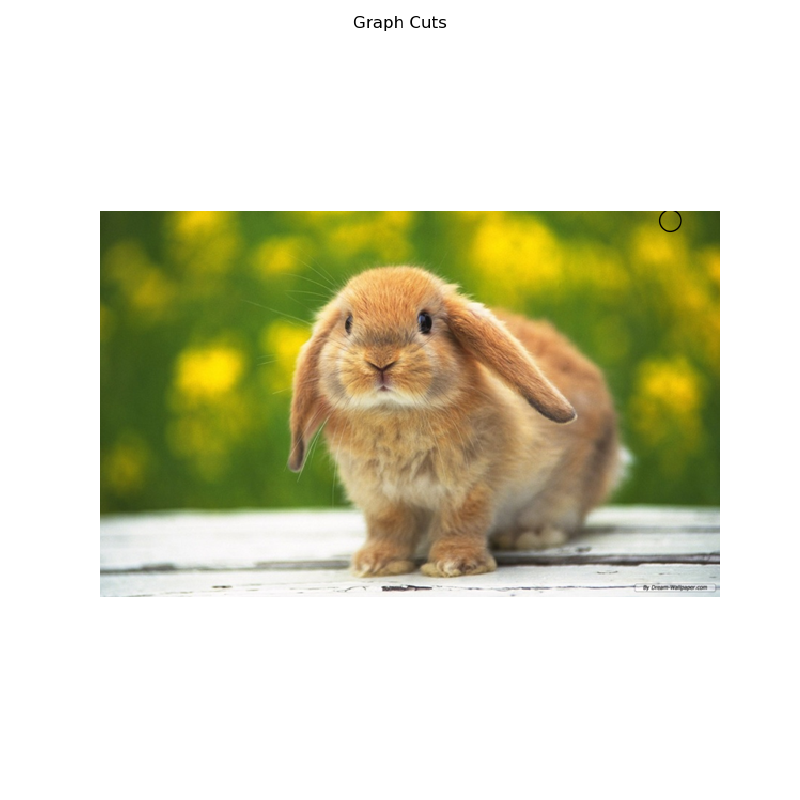

In [5]:
img1 = plt.imread('images/bunny.bmp')
app = MyGraphCuts(img1)
app.run()

### Show how your interactive segmenter works on more challanging images where there is some overlap between the color-models in the object and background (as in the "lama" image). Compare the results for $\lambda=0$ (no regularization) and for some $\lambda>0$. For convenience, you might want to include $\lambda$ in the list of parameters for the function "MyGraphcuts".

<IPython.core.display.Javascript object>


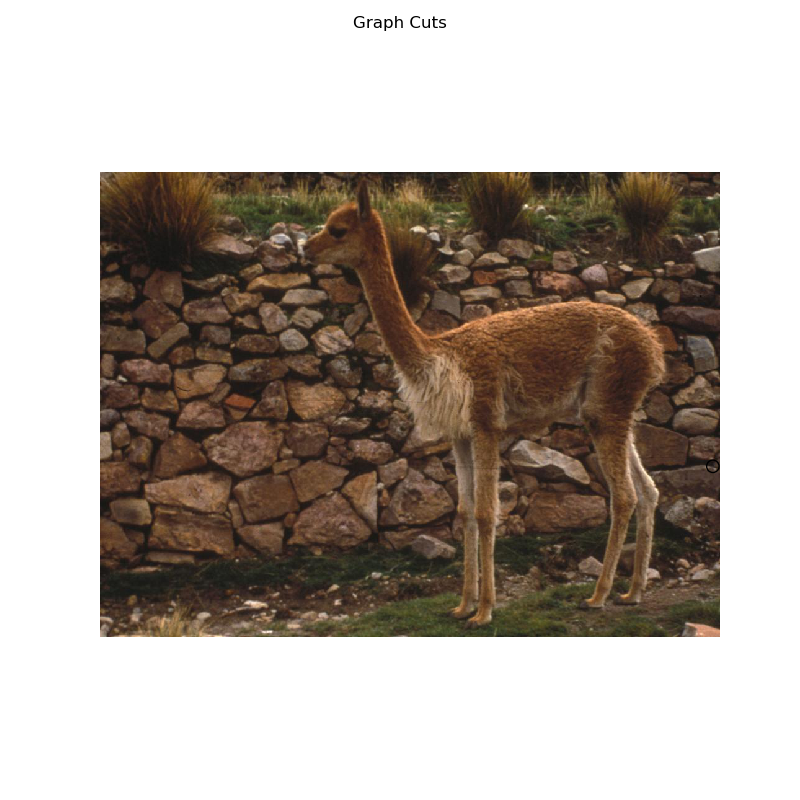

In [6]:
img2 = plt.imread('images/lama.jpg')
app = MyGraphCuts(img2)
app.run()